<a href="https://colab.research.google.com/github/Pankaj1357/HC18-Grand-Challenge/blob/master/HC18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

# **Mask Generation**
Done only once and replaced that  annotation with masks permanently
Did not changed the annotation file name though

## **Warning!!!**
Do not run below cells as task is already completed

In [2]:
train_pixel_file = pd.read_csv('training_set_pixel_size_and_HC.csv')
train_pixel_file.head()
# This Dataframe will be used to extract image names hence by doing image_name + '_Annotation' we will get annotation names

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [3]:
# This function takes annotation and spits out corresponding mask
def masking(image):
    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours,useless = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    return cv2.ellipse(image, ellipse, (255,255,255), -1)

training_set/000_HC_Annotation.png
training_set/001_HC_Annotation.png
training_set/002_HC_Annotation.png
training_set/003_HC_Annotation.png
training_set/004_HC_Annotation.png
training_set/005_HC_Annotation.png
training_set/006_HC_Annotation.png


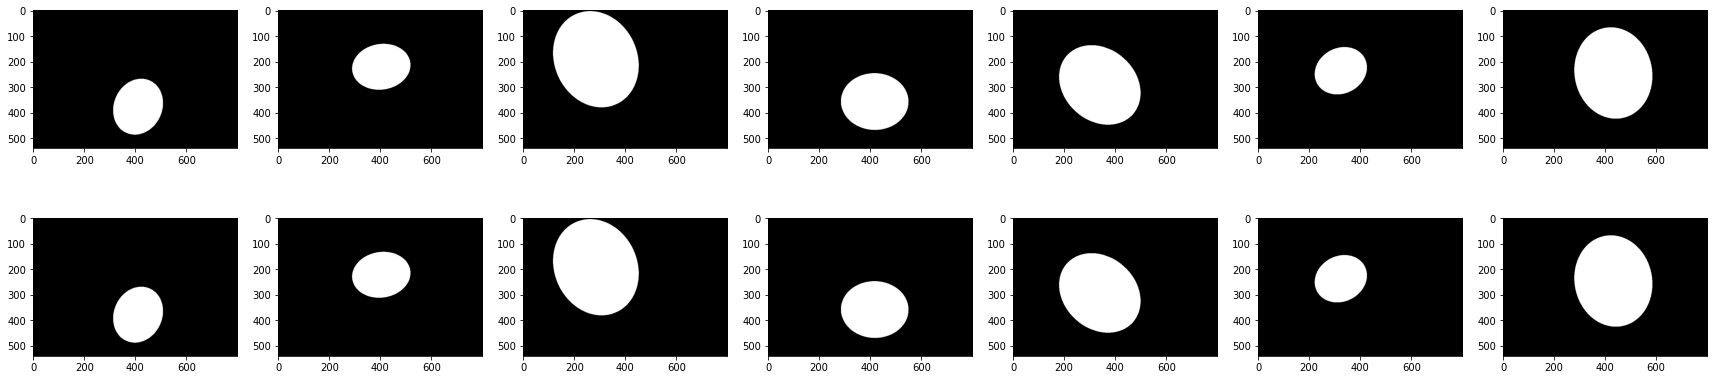

In [4]:
# to check if our masking function is working correctly
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
  print(file_path)
  ax = fig.add_subplot(2, 7, index+1)             ## annoted plot
  plt.imshow(cv2.imread(file_path))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(masking(cv2.imread(file_path)))        ## mask plot

In [5]:
# Here we loop through training set and  take annotations one by one and replace them with corresponding masks
fig = plt.figure(figsize = (30,7))
for index in range(len(train_pixel_file)):
    file_path = os.path.join('training_set', train_pixel_file.iloc[index, 0].replace('.png','_Annotation.png'))
    image = cv2.imread(file_path)
    mask = masking(image)
    cv2.imwrite(file_path, mask)

<Figure size 2160x504 with 0 Axes>

## **Warning!!!**
**Done with mask generation. Don't run above cells ever again**

### **Do all the imports in below cell**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage import io, color
from PIL import Image
import cv2

import os
import random

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [7]:
validation_set_size = 0.20            # fraction of dataset used for validation which will be splited randomly

In [8]:
# our dataset class
class HC18(Dataset):
  #""" train and validation dataset class"""
    def __init__(self, root_dir, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'training_set_pixel_size_and_HC.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        
        # lets split the dataset in train and validation
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)
        
    def __len__(self):
        
        if self.train:
          length = len(self.train_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
      
        if self.train:
          imx_name = os.path.join(self.root_dir, 'training_set', self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))

        else:
          imx_name = os.path.join(self.root_dir, 'training_set', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'training_set',self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)


          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        
        
        
        
        
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [9]:
# our datasets
tx_X = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((572, 572)),
                              transforms.ToTensor(),  ################ no need to normalize the maskk
                             # transforms.Normalize((0.5,), (0.5,))
                              ])
train_data = HC18('', train = True, transformX = tx_X, transformY = tx_Y)
validation_data = HC18('', train = False, transformX = tx_X, transformY = tx_Y )

In [10]:
# our dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2, shuffle = True, num_workers = 2 )
validation_loader = DataLoader(dataset = validation_data, batch_size = 2, shuffle = True, num_workers = 2)

In [11]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterX(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # unnormalizing the image # this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

In [12]:
# this function will return numpy array from the transformed tensors which were
# obtained from our train_loader. Just to plot them and see if they are intact :) ha ha
def im_converterY(tensor):
    image = tensor.cpu().clone().detach().numpy() # make copy of tensor and converting it to numpy as we will need original later
    image = image.transpose(1,2,0) # swapping axes making (1, 28, 28) image to a (28, 28, 1)
 # print(image.shape)
    image = image * np.array((1, 1, 1)) # unnormalizing the image  not needed# this also outputs (28, 28, 3) which seems important for plt.imshow
    image = image.clip(0, 1) # to make sure final values are in range 0 to 1 as .ToTensor outputed
    return image

0 torch.Size([2, 1, 572, 572]) torch.Size([2, 1, 572, 572])


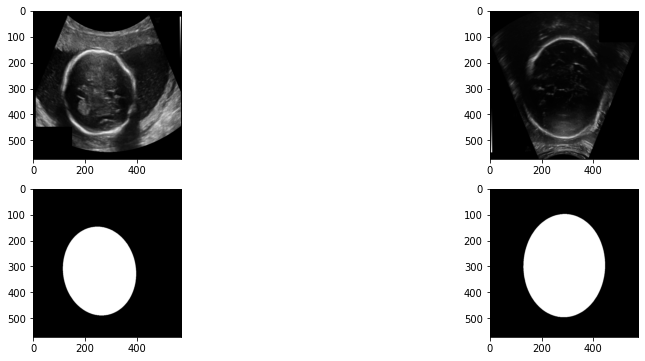

In [13]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
for ith_batch, sample_batched in enumerate(train_loader):
    print(ith_batch, sample_batched['image'].size(), sample_batched['annotation'].size())
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(sample_batched['image'][index]))
        ax = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(sample_batched['annotation'][index]))
    break

In [14]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.7),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            #nn.Dropout2d(0.77),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear: #upsampling will not be learnable
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:  # it will be learnable here
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 64)
#         self.down4 = down(512, 512)
        self.up1 = up(128, 32, bilinear = False) # upsampling weights are made learnable
        self.up2 = up(64, 16, bilinear = False)
        self.up3 = up(32, 8, bilinear = False)
#         self.up4 = up(32, 8, bilinear = False)
        self.outc = outconv(8, n_classes)
        self.dropout = torch.nn.Dropout2d(0.5)

    def forward(self, x):
        x = x.float()
        x1 = self.inc(x)
        x2 = self.down1(x1)
       # x2 = self.dropout(x2)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
#         x5 = self.down4(x4)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
#         x = self.dropout(x)
        x = self.up3(x, x1)
        #x = self.dropout(x) #
#         x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)
      
      
      
      
      
      
model = UNet(1, 1)
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0077)

In [17]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

In [18]:
# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
  
  dice_loss = 1 -(dice_index(y_predict, y_train))
  
  return dice_loss
  

In [19]:
epochs = 100


train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
  train_running_loss = 0.0
  validation_running_loss = 0.0
  
  model.train()
  
  for ith_batch, sample_batched in enumerate(train_loader):
    X_train = sample_batched['image'].to('cuda')
    y_train = sample_batched['annotation'].to('cuda')
    
    #X_train.requires_grad = True
    #y_train.requires_grad = True

    #print(ith_batch) #, X_train.size(), y_train.size())

    optimizer.zero_grad()
    y_pred = model(X_train)
   # out = (y_pred + 0.5).int().float()
    
    loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
    #loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if ith_batch % 50 == 0:
      print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
      
    train_running_loss += loss.item()
    
    
    
    
  else:
    with torch.no_grad():
      
      model.eval()
      
      for ith_batch, sample_batched in enumerate(validation_loader):
          X_val = sample_batched['image'].to('cuda')
          y_val = sample_batched['annotation'].to('cuda')
          
          
          
          y_out = model(X_val)
          out_val = (y_out + 0.5).int().float()
          
          val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
          
          #val_loss = criterion(y_out, y_val)
          
          validation_running_loss += val_loss.item()
      print("================================================================================")
      print("Epoch {} completed".format(e + 1))
      
      train_epoch_loss = train_running_loss / len(train_loader)
      validation_epoch_loss = validation_running_loss / len(validation_loader)
      
      print("Average train loss is {}: ".format(train_epoch_loss))
      print("Average validation loss is {}".format(validation_epoch_loss))
      print("================================================================================")
      train_running_loss_history.append(train_epoch_loss)
      validation_running_loss_history.append(validation_epoch_loss)
  
  torch.cuda.empty_cache()
      #print(y_pred.shape)

    #y_pred = y_pred.to('cpu')
    #X_train = X_train.to('cpu')

    #del y_train
    #torch.cuda.empty_cache()
    #if ith_batch ==100:
    #break
  #for index in range(2):
  #         ax = gig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
   #         plt.imshow(im_converter(X_train[index]))
    #        ax = gig.add_subplot(2, 2, index + 3)
     #       plt.imshow(im_converter(y_pred[index]))
  
    
  
   
  

  
  
  
    

Epoch:  1 Batch:  0 Current Loss:  0.8253040909767151
Epoch:  1 Batch:  50 Current Loss:  0.5772067904472351
Epoch:  1 Batch:  100 Current Loss:  0.46765536069869995
Epoch:  1 Batch:  150 Current Loss:  0.4878963530063629
Epoch:  1 Batch:  200 Current Loss:  0.349727988243103
Epoch:  1 Batch:  250 Current Loss:  0.355512797832489
Epoch:  1 Batch:  300 Current Loss:  0.4166223108768463
Epoch:  1 Batch:  350 Current Loss:  0.39204344153404236
Epoch 1 completed
Average train loss is 0.45331440940499307: 
Average validation loss is 1.2099029487371444
Epoch:  2 Batch:  0 Current Loss:  0.47810888290405273
Epoch:  2 Batch:  50 Current Loss:  0.41579675674438477
Epoch:  2 Batch:  100 Current Loss:  0.38348662853240967
Epoch:  2 Batch:  150 Current Loss:  0.4033842086791992
Epoch:  2 Batch:  200 Current Loss:  0.427565336227417
Epoch:  2 Batch:  250 Current Loss:  0.3508623242378235
Epoch:  2 Batch:  300 Current Loss:  0.44430243968963623
Epoch:  2 Batch:  350 Current Loss:  0.3022621273994446

Epoch:  12 Batch:  250 Current Loss:  0.22036920487880707
Epoch:  12 Batch:  300 Current Loss:  0.14779311418533325
Epoch:  12 Batch:  350 Current Loss:  0.24517874419689178
Epoch 12 completed
Average train loss is 0.24351182842627167: 
Average validation loss is 0.2826087377220392
Epoch:  13 Batch:  0 Current Loss:  0.14879761636257172
Epoch:  13 Batch:  50 Current Loss:  0.20141123235225677
Epoch:  13 Batch:  100 Current Loss:  0.22921083867549896
Epoch:  13 Batch:  150 Current Loss:  0.21593640744686127
Epoch:  13 Batch:  200 Current Loss:  0.26746615767478943
Epoch:  13 Batch:  250 Current Loss:  0.1895751953125
Epoch:  13 Batch:  300 Current Loss:  0.2734386622905731
Epoch:  13 Batch:  350 Current Loss:  0.279441237449646
Epoch 13 completed
Average train loss is 0.23802578363567592: 
Average validation loss is 0.23674181319773197
Epoch:  14 Batch:  0 Current Loss:  0.13111814856529236
Epoch:  14 Batch:  50 Current Loss:  0.15327633917331696
Epoch:  14 Batch:  100 Current Loss:  0.

Epoch 23 completed
Average train loss is 0.19525970567017795: 
Average validation loss is 0.285962016582489
Epoch:  24 Batch:  0 Current Loss:  0.13544060289859772
Epoch:  24 Batch:  50 Current Loss:  0.18531927466392517
Epoch:  24 Batch:  100 Current Loss:  0.15463879704475403
Epoch:  24 Batch:  150 Current Loss:  0.22019174695014954
Epoch:  24 Batch:  200 Current Loss:  0.27629244327545166
Epoch:  24 Batch:  250 Current Loss:  0.19059406220912933
Epoch:  24 Batch:  300 Current Loss:  0.2269994020462036
Epoch:  24 Batch:  350 Current Loss:  0.19975969195365906
Epoch 24 completed
Average train loss is 0.19293381257914008: 
Average validation loss is 0.46636880867183206
Epoch:  25 Batch:  0 Current Loss:  0.09822145104408264
Epoch:  25 Batch:  50 Current Loss:  0.16068337857723236
Epoch:  25 Batch:  100 Current Loss:  0.11713690310716629
Epoch:  25 Batch:  150 Current Loss:  0.21901144087314606
Epoch:  25 Batch:  200 Current Loss:  0.17845642566680908
Epoch:  25 Batch:  250 Current Loss

Epoch:  35 Batch:  0 Current Loss:  0.22019410133361816
Epoch:  35 Batch:  50 Current Loss:  0.15061435103416443
Epoch:  35 Batch:  100 Current Loss:  0.27809998393058777
Epoch:  35 Batch:  150 Current Loss:  0.09780547022819519
Epoch:  35 Batch:  200 Current Loss:  0.11673349142074585
Epoch:  35 Batch:  250 Current Loss:  0.11694575846195221
Epoch:  35 Batch:  300 Current Loss:  0.10304287821054459
Epoch:  35 Batch:  350 Current Loss:  0.13094384968280792
Epoch 35 completed
Average train loss is 0.16731460059061645: 
Average validation loss is 0.2107336625084281
Epoch:  36 Batch:  0 Current Loss:  0.18906210362911224
Epoch:  36 Batch:  50 Current Loss:  0.18793036043643951
Epoch:  36 Batch:  100 Current Loss:  0.17838120460510254
Epoch:  36 Batch:  150 Current Loss:  0.08059035241603851
Epoch:  36 Batch:  200 Current Loss:  0.11095485836267471
Epoch:  36 Batch:  250 Current Loss:  0.204067200422287
Epoch:  36 Batch:  300 Current Loss:  0.11552247405052185
Epoch:  36 Batch:  350 Curren

Epoch:  46 Batch:  150 Current Loss:  0.07455123960971832
Epoch:  46 Batch:  200 Current Loss:  0.15866297483444214
Epoch:  46 Batch:  250 Current Loss:  0.1289663165807724
Epoch:  46 Batch:  300 Current Loss:  0.1469135731458664
Epoch:  46 Batch:  350 Current Loss:  0.20685966312885284
Epoch 46 completed
Average train loss is 0.15745833804830908: 
Average validation loss is 0.20590661730617285
Epoch:  47 Batch:  0 Current Loss:  0.2869337797164917
Epoch:  47 Batch:  50 Current Loss:  0.1379639357328415
Epoch:  47 Batch:  100 Current Loss:  0.3250581920146942
Epoch:  47 Batch:  150 Current Loss:  0.17417815327644348
Epoch:  47 Batch:  200 Current Loss:  0.16935473680496216
Epoch:  47 Batch:  250 Current Loss:  0.26738423109054565
Epoch:  47 Batch:  300 Current Loss:  0.287690669298172
Epoch:  47 Batch:  350 Current Loss:  0.11497363448143005
Epoch 47 completed
Average train loss is 0.1580472215823829: 
Average validation loss is 0.274135108217597
Epoch:  48 Batch:  0 Current Loss:  0.1

Epoch:  57 Batch:  350 Current Loss:  0.21537834405899048
Epoch 57 completed
Average train loss is 0.14708675840869545: 
Average validation loss is 0.1943707286566496
Epoch:  58 Batch:  0 Current Loss:  0.12488923966884613
Epoch:  58 Batch:  50 Current Loss:  0.1819949746131897
Epoch:  58 Batch:  100 Current Loss:  0.12236382067203522
Epoch:  58 Batch:  150 Current Loss:  0.11182144284248352
Epoch:  58 Batch:  200 Current Loss:  0.19148801267147064
Epoch:  58 Batch:  250 Current Loss:  0.0733163058757782
Epoch:  58 Batch:  300 Current Loss:  0.17853933572769165
Epoch:  58 Batch:  350 Current Loss:  0.08429904282093048
Epoch 58 completed
Average train loss is 0.1475654769409448: 
Average validation loss is 0.33643123246729373
Epoch:  59 Batch:  0 Current Loss:  0.2187989503145218
Epoch:  59 Batch:  50 Current Loss:  0.17409764230251312
Epoch:  59 Batch:  100 Current Loss:  0.17401260137557983
Epoch:  59 Batch:  150 Current Loss:  0.19872455298900604
Epoch:  59 Batch:  200 Current Loss: 

Epoch:  69 Batch:  0 Current Loss:  0.15544846653938293
Epoch:  69 Batch:  50 Current Loss:  0.2329532951116562
Epoch:  69 Batch:  100 Current Loss:  0.11624211072921753
Epoch:  69 Batch:  150 Current Loss:  0.14193731546401978
Epoch:  69 Batch:  200 Current Loss:  0.11451773345470428
Epoch:  69 Batch:  250 Current Loss:  0.1774037480354309
Epoch:  69 Batch:  300 Current Loss:  0.10785531997680664
Epoch:  69 Batch:  350 Current Loss:  0.070803701877594
Epoch 69 completed
Average train loss is 0.13926359253935516: 
Average validation loss is 0.2494118093699217
Epoch:  70 Batch:  0 Current Loss:  0.10451991111040115
Epoch:  70 Batch:  50 Current Loss:  0.18079161643981934
Epoch:  70 Batch:  100 Current Loss:  0.08829735964536667
Epoch:  70 Batch:  150 Current Loss:  0.16580116748809814
Epoch:  70 Batch:  200 Current Loss:  0.08591528236865997
Epoch:  70 Batch:  250 Current Loss:  0.22116582095623016
Epoch:  70 Batch:  300 Current Loss:  0.0606381893157959
Epoch:  70 Batch:  350 Current L

Epoch:  80 Batch:  150 Current Loss:  0.11621582508087158
Epoch:  80 Batch:  200 Current Loss:  0.1979358047246933
Epoch:  80 Batch:  250 Current Loss:  0.09048783034086227
Epoch:  80 Batch:  300 Current Loss:  0.15835954248905182
Epoch:  80 Batch:  350 Current Loss:  0.06404805928468704
Epoch 80 completed
Average train loss is 0.1349863766785711: 
Average validation loss is 0.3229443147033453
Epoch:  81 Batch:  0 Current Loss:  0.10121507197618484
Epoch:  81 Batch:  50 Current Loss:  0.22682461142539978
Epoch:  81 Batch:  100 Current Loss:  0.16063086688518524
Epoch:  81 Batch:  150 Current Loss:  0.04483745992183685
Epoch:  81 Batch:  200 Current Loss:  0.10675974190235138
Epoch:  81 Batch:  250 Current Loss:  0.1777268946170807
Epoch:  81 Batch:  300 Current Loss:  0.09140422195196152
Epoch:  81 Batch:  350 Current Loss:  0.18643489480018616
Epoch 81 completed
Average train loss is 0.1339655196201056: 
Average validation loss is 0.16022489622235297
Epoch:  82 Batch:  0 Current Loss:

Epoch:  91 Batch:  300 Current Loss:  0.17202128469944
Epoch:  91 Batch:  350 Current Loss:  0.08157610893249512
Epoch 91 completed
Average train loss is 0.12919089029543102: 
Average validation loss is 0.18493312127888203
Epoch:  92 Batch:  0 Current Loss:  0.15971378982067108
Epoch:  92 Batch:  50 Current Loss:  0.1720239222049713
Epoch:  92 Batch:  100 Current Loss:  0.06364975869655609
Epoch:  92 Batch:  150 Current Loss:  0.05673348158597946
Epoch:  92 Batch:  200 Current Loss:  0.16346526145935059
Epoch:  92 Batch:  250 Current Loss:  0.07026558369398117
Epoch:  92 Batch:  300 Current Loss:  0.12063634395599365
Epoch:  92 Batch:  350 Current Loss:  0.20915664732456207
Epoch 92 completed
Average train loss is 0.12814562496729195: 
Average validation loss is 0.1918212665989995
Epoch:  93 Batch:  0 Current Loss:  0.06693124026060104
Epoch:  93 Batch:  50 Current Loss:  0.17857006192207336
Epoch:  93 Batch:  100 Current Loss:  0.21272021532058716
Epoch:  93 Batch:  150 Current Loss: 

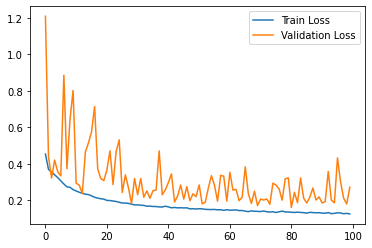

In [20]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [21]:
model.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [22]:
out = (y_pred + 0.5).int().float()

In [23]:
print(dice_index(y_train, out))
print(dice_loss(y_train, out))

tensor(0.7714, device='cuda:0')
tensor(0.2286, device='cuda:0')


In [24]:
# pig = plt.figure(figsize = (15, 6))

# a = pig.add_subplot(2, 3, 1)
# plt.imshow(im_converterX(X_train[0]))

# a = pig.add_subplot(2, 3, 2)
# plt.imshow(im_converterY(y_train[0]))

# a = pig.add_subplot(2, 3, 3)
# plt.imshow(im_converterY(out[0]))


# a = pig.add_subplot(2, 3, 4)
# plt.imshow(im_converterX(X_train[1]))

# a = pig.add_subplot(2, 3, 5)
# plt.imshow(im_converterY(y_train[1]))

# a = pig.add_subplot(2, 3, 6)
# plt.imshow(im_converterY(out[1]))

In [25]:
gg = dice_index(out, y_train)
print(gg)
print(dice_loss(out, y_train))

tensor(0.7714, device='cuda:0')
tensor(0.2286, device='cuda:0')


In [26]:
class HC18_test(Dataset):
    def __init__(self, root_dir, transformX = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'test_set_pixel_size.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        
    def __len__(self):
        return len(self.pixel_file)
    
    def __getitem__(self, index):
        imx_name = os.path.join(self.root_dir, 'test_set', self.pixel_file.iloc[index, 0])
        
        imx = Image.open(imx_name)
        
        f_name = self.pixel_file.iloc[index, 0]
        
        if self.transformX :
            imx = self.transformX(imx)
        
        sample = {'image': imx, 'f_name': f_name}
        return sample

In [27]:
test_data = HC18_test('', transformX = tx_X)

In [28]:
test_data

In [29]:
test_loader = DataLoader(dataset = test_data, batch_size = 2, shuffle = True)

In [30]:
test_loader

0 torch.Size([2, 1, 572, 572])


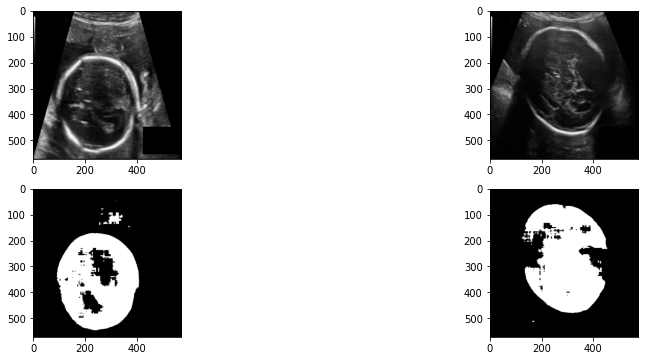

In [31]:
## Here we loop through our train_loader and see the images
## Looks good
fig = plt.figure(figsize = (15,6))
#model.to('cpu')
for ith_batch, sample_batched in enumerate(test_loader):
  
    X_test = sample_batched['image'].to('cuda')
    print(ith_batch, X_test.size())
    
    y_test = (model(X_test) + 0.5).int().float()
    
    
    
    for index in range(2):
        ax = fig.add_subplot(2, 2 , index + 1)  # subplot index starts from 1
        plt.imshow(im_converterX(X_test[index]))
        
        ax  = fig.add_subplot(2, 2, index + 3)
        plt.imshow(im_converterY(y_test[index]))
    break

In [32]:
def avg_dice_index(dataloader):
  
    dice = 0.0
    model.eval()
    with torch.no_grad():
    
        for ith_batch, sample_batched in enumerate(dataloader):
  
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            
            y_predict = (model(X_train) + 0.5).int().float()
            
            dice += dice_index(y_predict, y_train)
            
            
            
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [33]:
avg_dice_index(validation_loader)    #### Dice index of validation data

0.7994515299797058

In [34]:
avg_dice_index(train_loader)        ### Dice index of training data

0.7563550472259521

In [35]:
test_loader = DataLoader(dataset = test_data, batch_size = 1, shuffle = True) # to write image files

## **Warning!!!**
### Your are about to write on drive

In [36]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])
    
with torch.no_grad():
      #model.eval()
      for ith_batch , sample in enumerate(test_loader):
        X_test = sample['image'].to('cuda')
        y_pred = (model(X_test) + 0.5).int().float().cpu()
#         print(335-ith_batch)
        
        file_names = sample['f_name']
        pankaj = transform(y_pred[0])
        #singh = transform(y_pred[1])
        torchvision.utils.save_image(pankaj , os.path.join('segmented', file_names[0]))
        #torchvision.utils.save_image(singh, os.path.join('/content/drive/My Drive/HC18/test_set', file_names[1].replace('.png','_Annotation.png')))
      print("Segmentation files written")
        
        

Segmentation files written


In [37]:
def fit_ellipse(im):    
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(imgray,127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [len(contour) for contour in contours]
    ellipse = cv2.fitEllipse(contours[np.argmax(contour_sizes)])
    return ellipse

In [38]:
file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

In [39]:
df_pixel_size = pd.read_csv('test_set_pixel_size.csv')
submission = {'filename': [], 'center_x_mm': [], 'center_y_mm': [], 'semi_axes_a_mm': [],
             'semi_axes_b_mm': [], 'angle_rad': [], 'Index': []}

file_names = sorted([file for _,_,files in os.walk('segmented/') for file in files])

for i, file_name in enumerate(file_names):
    im = cv2.imread('segmented/'+file_name)
   # file_name = file_name.replace('_Segmented', '')
    ellipse = fit_ellipse(im)
    im_mask = cv2.ellipse(np.zeros_like(im),ellipse,(255,255,255),-1)
    image_name = file_name.split('.')[0] + '_Annotation_fit.png'
    #cv2.imwrite('/content/drive/My Drive/HC18/test_set/'+image_name, im_mask)
    
    pixel_size = df_pixel_size.loc[df_pixel_size['filename'] == file_name, 'pixel size(mm)'].iloc[0]
    submission['filename'].extend([file_name])
    submission['Index'].extend([int(file_name.split('_')[0])])
    center_x,  center_y = ellipse[0]
    submission['center_x_mm'].extend([pixel_size*center_x])
    submission['center_y_mm'].extend([pixel_size*center_y])
    semi_axes_b, semi_axes_a = ellipse[1]
    if semi_axes_b > semi_axes_a:
        semi_axes_b = semi_axes_b + semi_axes_a
        semi_axes_a = semi_axes_b - semi_axes_a
        semi_axes_b -= semi_axes_a
    submission['semi_axes_a_mm'].extend([semi_axes_a*pixel_size/2])
    submission['semi_axes_b_mm'].extend([semi_axes_b*pixel_size/2])
    angle = ellipse[2]
    if angle < 90:
        angle += 90
    else:
        angle -= 90
    submission['angle_rad'].extend([np.deg2rad(angle)])
    
submission = pd.DataFrame(submission)
submission = submission[['filename', 'center_x_mm', 'center_y_mm', 
                         'semi_axes_a_mm', 'semi_axes_b_mm', 'angle_rad', 'Index']]    
submission = submission.sort_values(['Index'])
submission = submission.drop('Index', axis=1)
submission.to_csv("simple_unet.csv", index=False)
print('Required .csv file generated')

Required .csv file generated


In [40]:
q = pd.read_csv('simple_unet.csv')  ## to check theck the generated csv

In [41]:
print('Length of csv file: ',len(q))

Length of csv file:  335


In [42]:
submission.head()

,filename,center_x_mm,center_y_mm,semi_axes_a_mm,semi_axes_b_mm,angle_rad
0,000_HC.png,93.742805,67.208589,46.179850,38.835914,2.807191
1,001_HC.png,30.631401,16.033920,10.413698,4.138373,0.015959
2,002_HC.png,62.857248,42.359525,35.201004,30.031441,0.162662
3,003_HC.png,35.883729,34.241905,26.174435,15.938692,3.019152
4,004_HC.png,79.291191,43.906192,44.872564,26.125215,0.054685
